<a href="https://colab.research.google.com/github/trvslhlt/ift_6390_machine_learning/blob/learning-problem/exercises/01_learning_problem/examples.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# KNN

Exercises from [course notes](https://pierrelucbacon.com/mlbook/knn/#exercices)

**Run all cells to verify your setup.**

In [63]:
# ==============================================================================
# Environment Setup - Run this cell first!
# ==============================================================================
# This cell handles both local and Google Colab environments.
# Copy this cell to the start of every notebook.

import sys
from pathlib import Path

IN_COLAB = "google.colab" in sys.modules

if IN_COLAB:
    import subprocess

    REPO_URL = "https://github.com/trvslhlt/ift_6390_machine_learning.git"
    REPO_PATH = Path("/content/ift_6390_machine_learning")

    if REPO_PATH.exists():
        print("Updating repository...")
        subprocess.run(["git", "-C", str(REPO_PATH), "pull"], check=True)
    else:
        print("Cloning repository...")
        subprocess.run(["git", "clone", REPO_URL, str(REPO_PATH)], check=True)

    print("Installing dependencies...")
    %pip install -q -e {REPO_PATH}

    sys.path.insert(0, str(REPO_PATH / "src"))
    %cd {REPO_PATH}
else:
    # Local: find repo root and add src to path
    REPO_PATH = Path.cwd()
    while not (REPO_PATH / "pyproject.toml").exists() and REPO_PATH != REPO_PATH.parent:
        REPO_PATH = REPO_PATH.parent
    sys.path.insert(0, str(REPO_PATH / "src"))

print(f"\nEnvironment: {'Google Colab' if IN_COLAB else 'Local'}")
print(f"Repository: {REPO_PATH}")


Environment: Local
Repository: /Users/travisholt/Documents/github/trvslhlt/ift_6390_machine_learning


## Exercise 1: Manual Classification

Considérez les points d'entraînement suivants en 2D:

| Point | $x_1$ | $x_2$ | Classe |
|-------|-------|-------|--------|
| A | 0 | 0 | 0 |
| B | 1 | 0 | 0 |
| C | 0 | 1 | 1 |
| D | 2 | 2 | 1 |
| E | 3 | 1 | 1 |

1. Pour le point requête $x = (1, 1)$, identifiez les 3 plus proches voisins avec la distance euclidienne. Quelle est la prédiction du 3-ppv?

2. Répétez avec $k = 1$ et $k = 5$. Les prédictions changent-elles?

3. Calculez les distances avec la norme $\ell_1$ (Manhattan). Les 3 plus proches voisins sont-ils les mêmes?

In [64]:
import math

# hyperparams
k = 3

# samples
A = [0, 0, 0]
B = [1, 0, 0]
C = [0, 1, 1]
D = [2, 2, 1]
E = [3, 1, 1]
points = [A, B, C, D, E]

# to predict
x = [1, 1]

# compute distances
def distance(p1, p2):
    return math.sqrt(pow(p1[0] - p2[0], 2) + pow(p1[1] - p2[1], 2))
distances = [(distance(x, point[:2]), point[-1]) for point in points]
distances.sort(key=lambda d: d[0])

## note:
# there are samples with the same distance from the test point that have different classes.
# how we determine the nearest neighbors may affect the final prediction.
print(distances)

# get nearest neighbors
neighbors = distances[:k]

# count class occurrences
counts: dict[int, int] = {}
for neighbor in neighbors:
    dist, c = neighbor
    count = counts.get(c, 0)
    counts[c] = count + 1

# get most common class in neighbors
prediction = max(counts, key=lambda c: counts.get(c, 0))
print(f"The predicted class for point {x} is: {prediction}")

[(1.0, 0), (1.0, 1), (1.4142135623730951, 0), (1.4142135623730951, 1), (2.0, 1)]
The predicted class for point [1, 1] is: 0


## Example 2: Effect of Normalization

Un jeu de données contient deux variables: l'âge (entre 20 et 70 ans) et le revenu annuel (entre 20 000 et 200 000 dollars).

1. Calculez la distance euclidienne entre les points $x_1 = (30, 50000)$ et $x_2 = (35, 51000)$.

2. Calculez la distance entre $x_1 = (30, 50000)$ et $x_3 = (31, 150000)$.

3. Laquelle des deux paires est "plus proche"? Ce résultat est-il intuitivement raisonnable?

4. Proposez une transformation des données qui rendrait les deux variables comparables. Recalculez les distances après transformation.

In [65]:
import math

def l2_distance(p1, p2):
    return math.sqrt(pow(p1[0] - p2[0], 2) + pow(p1[1] - p2[1], 2))

# 1
x1 = [30, 50000]
x2 = [35, 51000]
x1_x2_distance = l2_distance(x1, x2) 
print(f'{x1_x2_distance=}')

# 2
x3 = [31 ,150000]
x1_x3_distance = l2_distance(x1, x3) 
print(f'{x1_x3_distance=}')

# 3
print(f'x1 is closer to x2 than x3: {x1_x2_distance < x1_x3_distance}\n')
## this makes sense because the greatest contribution to these distances comes from the income feature
## which is largest between x1 and x3.
## But, we are likely interested in both features so we need to do something to make them comparable.

# 4
## we can normalize the features to have values 
def normalize_min_max(p, in_ranges, out_ranges):
    x_in_range, y_in_range = in_ranges
    x_out_range, y_out_range = out_ranges
    x = (p[0] - x_in_range[0]) / (x_in_range[1] - x_in_range[0]) * (x_out_range[1] - x_out_range[0]) + x_out_range[0]
    y = (p[1] - y_in_range[0]) / (y_in_range[1] - y_in_range[0]) * (y_out_range[1] - y_out_range[0]) + y_out_range[0]
    return [x, y]

def normalize_standardization(p, means, stddevs):
    x = (p[0] - means[0]) / stddevs[0]
    y = (p[1] - means[1]) / stddevs[1]
    return [x, y]

in_ranges = [(20, 60), (0, 200000)]
out_ranges = [(0, 1), (0, 1)]
x1_normalized = normalize_min_max(x1, in_ranges, out_ranges)
x2_normalized = normalize_min_max(x2, in_ranges, out_ranges)
x3_normalized = normalize_min_max(x3, in_ranges, out_ranges)
print(f'{x1_normalized=}, {x2_normalized=}, {x3_normalized=}')

x1_x2_distance_normalized = l2_distance(x1_normalized, x2_normalized) 
x1_x3_distance_normalized = l2_distance(x1_normalized, x3_normalized) 
print(f'{x1_x2_distance_normalized=}')
print(f'{x1_x3_distance_normalized=}')
print(f'x1 is closer to x2 than x3 (normalized_min_max): {x1_x2_distance_normalized < x1_x3_distance_normalized}\n')

means = [45, 110000]
stddevs = [15, 60000]
x1_standardized = normalize_standardization(x1, means, stddevs)
x2_standardized = normalize_standardization(x2, means, stddevs)
x3_standardized = normalize_standardization(x3, means, stddevs)
print(f'{x1_standardized=}, {x2_standardized=}, {x3_standardized=}')

x1_x2_distance_standardized = l2_distance(x1_standardized, x2_standardized) 
x1_x3_distance_standardized = l2_distance(x1_standardized, x3_standardized) 
print(f'{x1_x2_distance_standardized=}')
print(f'{x1_x3_distance_standardized=}')
print(f'x1 is closer to x2 than x3 (standardized): {x1_x2_distance_standardized < x1_x3_distance_standardized}\n')

x1_x2_distance=1000.0124999218759
x1_x3_distance=100000.000005
x1 is closer to x2 than x3: True

x1_normalized=[0.25, 0.25], x2_normalized=[0.375, 0.255], x3_normalized=[0.275, 0.75]
x1_x2_distance_normalized=0.12509996003196805
x1_x3_distance_normalized=0.5006246098625197
x1 is closer to x2 than x3 (normalized_min_max): True

x1_standardized=[-1.0, -1.0], x2_standardized=[-0.6666666666666666, -0.9833333333333333], x3_standardized=[-0.9333333333333333, 0.6666666666666666]
x1_x2_distance_standardized=0.33374973990834644
x1_x3_distance_standardized=1.667999467092907
x1 is closer to x2 than x3 (standardized): True



## Exercise 3: Bias-variance trade-off

Soit un problème de régression 1D où la vraie fonction est $f(x) = \sin(2\pi x)$ et les observations sont bruitées: $y = f(x) + \varepsilon$ avec $\varepsilon \sim \mathcal{N}(0, 0.1)$.

1. Générez 50 points d'entraînement uniformément répartis sur $[0, 1]$.

2. Implémentez la régression k-ppv et tracez les prédictions pour $k = 1, 5, 20, 50$.

3. Calculez l'erreur quadratique moyenne (MSE) sur un ensemble de test de 200 points pour chaque valeur de $k$.

4. Tracez le MSE en fonction de $k$. Quelle valeur de $k$ minimise l'erreur de test?

5. Que se passe-t-il quand $k = N$ (nombre total de points d'entraînement)?

Lowest MSE is for k=3 with MSE=0.0058828278487967674


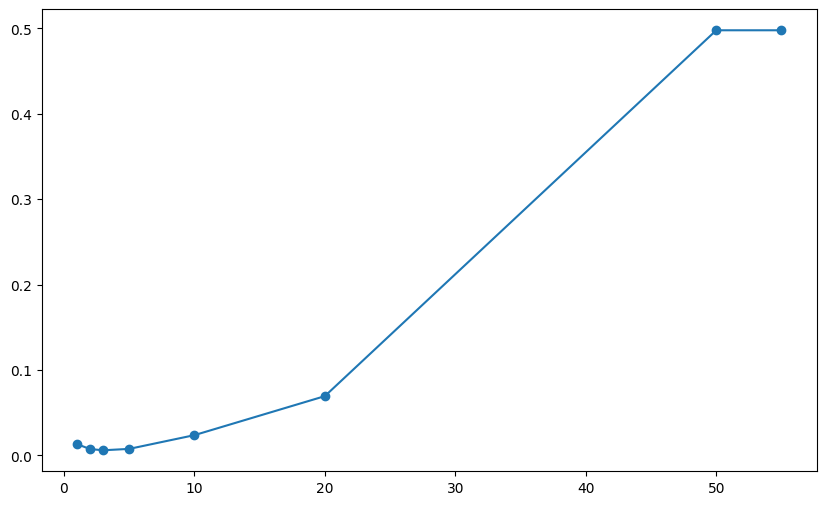

In [66]:
import numpy as np
import matplotlib.pyplot as plt

np.random.seed(0)
figure_size = (10, 6)
N = 50

# 1
X_train = np.linspace(0, 1, N)
y_train = np.sin(2 * np.pi * X_train) + np.random.randn(N) * 0.1
# 2
def knn_regression(train_X, train_y, test_X, k):
    predictions = []
    for x in test_X:
        distances = np.abs(train_X - x)
        knn_indices = np.argsort(distances)[:k]
        knn_values = train_y[knn_indices]
        prediction = np.mean(knn_values)
        predictions.append(prediction)
    return np.array(predictions)

# 3 - 4
ks = [1, 2, 3, 5, 10, 20, N, N + 5]
X_test = np.linspace(0, 1, 200)
y_test_true = np.sin(2 * np.pi * X_test)
y_tests = {k: knn_regression(X_train, y_train, X_test, k) for k in ks}

MSEs = {k: np.mean((y_tests[k] - y_test_true) ** 2) for k in ks}
lowest_mse_k = min(MSEs, key=lambda k: MSEs[k])
print(f'Lowest MSE is for k={lowest_mse_k} with MSE={MSEs[lowest_mse_k]}')

# 5
plt.figure(figsize=figure_size)
plt.plot(list(MSEs.keys()), list(MSEs.values()), marker='o')

## Exercise 4: The Scourge of Dimensionality

Considérez $N = 1000$ points uniformément distribués dans l'hypercube $[0, 1]^d$.

1. Pour $d = 1, 2, 5, 10, 20, 50, 100$, calculez la distance moyenne au plus proche voisin parmi ces points. Utilisez la simulation Monte Carlo.

2. Tracez cette distance en fonction de $d$. Que constatez-vous?

3. Pour capturer les 10 plus proches voisins (soit 1% des données), quel est le rayon de la boule centrée sur un point arbitraire? Calculez ce rayon pour différentes dimensions.

4. Expliquez pourquoi les k-ppv deviennent inefficaces en haute dimension, même avec beaucoup de données.

Dimension	Avg NN Distance
1		0.0005
2		0.0161
5		0.1783
10		0.5043
20		1.0379
50		2.1157
100		3.3297

Dimension	Radius r for p=0.01
1		0.0100
2		0.1000
5		0.3981
10		0.6310
20		0.7943
50		0.9120
100		0.9550
0.0003141592653589794


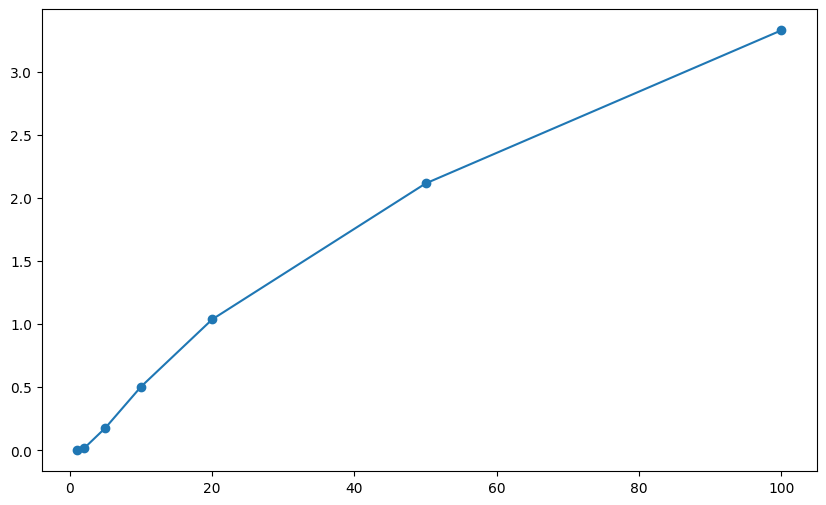

In [67]:
import math
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.distance import cdist

N = 1000
ds = [1, 2, 5, 10, 20, 50, 100]
rng = np.random.default_rng(0)

# 1
d_points = { d: rng.uniform(0, 1, size=(N, d)) for d in ds }

d_avg_nn_distances = {}
for d, points in d_points.items():
    distances = cdist(points, points)
    np.fill_diagonal(distances, np.inf)
    nearest_distances = distances.min(axis=1)
    avg_distance = nearest_distances.mean()
    d_avg_nn_distances[d] = avg_distance

print("Dimension\tAvg NN Distance")
for d, avg_distance in d_avg_nn_distances.items():
    print(f"{d}\t\t{avg_distance:.4f}")

# 2
plt.figure(figsize=(10, 6))
plt.plot(list(d_avg_nn_distances.keys()), list(d_avg_nn_distances.values()), marker='o')
# we see from the plot that the average nn distance increases nearly linearly with dimension

# 3 (approximation taken from course solution)
p = 0.01
rs = {}
for d in ds:
    r = math.pow(p, 1 / d)
    rs[d] = r
print("\nDimension\tRadius r for p=0.01")
for d, r in rs.items():
    print(f"{d}\t\t{r:.4f}")
print(p * math.pi * math.pow(0.1, 2))

# 4
# 1. the neighbors are no longer local
# 2. all neighbors become approximately equidistant
# 3. the local average becomes a global average, losing all information about the local structure of f(x)

## Exercise 5: Distances for text

Considérez trois documents représentés par leurs vecteurs de fréquence de mots (bag-of-words) sur un vocabulaire de 5 mots:

| Document | chat | chien | maison | voiture | arbre |
|----------|------|-------|--------|---------|-------|
| $d_1$ | 3 | 0 | 1 | 0 | 2 |
| $d_2$ | 2 | 1 | 0 | 0 | 1 |
| $d_3$ | 0 | 0 | 2 | 3 | 0 |

1. Calculez la distance euclidienne entre chaque paire de documents.

2. Calculez la similarité cosinus entre chaque paire, puis convertissez en distance ($d = 1 - \text{sim}$).

3. Selon chaque mesure, quels sont les deux documents les plus similaires?

4. Pourquoi la similarité cosinus est-elle souvent préférée pour les documents textuels?

In [68]:
# 1 calculate the euclidian distance between each pair of docs
words = ['cat', 'dog', 'house', 'car', 'tree']
documents = [
    [3, 0, 1, 0, 2],  # doc 1
    [2, 1, 0, 0, 1],  # doc 2
    [0, 0, 2, 3, 0],  # doc 3
]

X = np.array(documents)
X_distances_euc = cdist(X, X, metric='euclidean')

# 2 calc the cosine similarity between each pair of docs. then convert to distances (d = 1 - similarity)
X_distances_cos = cdist(X, X, metric='cosine')
X_sim_cos = 1 - X_distances_cos

# 3 according to each measure, which are the 2 most similar docs?
results_table = [
    ['documents', 'euclidian distance', 'cosine distance'],
    ['d1-d2', X_distances_euc[0,1], X_distances_cos[0,1]],
    ['d1-d3', X_distances_euc[0,2], X_distances_cos[0,2]],
    ['d2-d3', X_distances_euc[1,2], X_distances_cos[1,2]],
]
print("\nSimilarity Results:")
for row in results_table:
    print(f'{row[0]:<15} {row[1]:<20} {row[2]:<20}')
## Documents 2 and 3 are most similar according to both measures.

# 4 why is cosine similarity often preferred for text documents?
## 1. it is less sensitive to differences in document length
## 2. it focuses on the orientation of the vectors (the relative frequency of words)
## 3. bag-of-words representations are often high-dimensional and sparse, making cosine similarity more effective




Similarity Results:
documents       euclidian distance   cosine distance     
d1-d2           2.0                  0.12712843905603044 
d1-d3           4.795831523312719    0.8517501366677798  
d2-d3           4.358898943540674    1.0                 


## Exercise 6: Nadaraya-Watson

Soit les données d'entraînement: $x = [0, 1, 2, 3]$ et $y = [1, 2, 1.5, 3]$.

1. Avec un noyau gaussien $K_\lambda(u) = \exp(-u^2 / 2\lambda^2)$ et $\lambda = 0.5$, calculez manuellement la prédiction de Nadaraya-Watson pour $x^* = 1.5$.

2. Répétez avec $\lambda = 2$. Comment la prédiction change-t-elle?

3. Implémentez l'estimateur et tracez les prédictions pour $\lambda = 0.2, 0.5, 1, 2$ sur l'intervalle $[0, 3]$.

4. Comparez visuellement avec la régression k-ppv pour $k = 1, 2, 3$. Quelle méthode produit des prédictions plus lisses?

Prediction for x=1.5 with lambda=0.5: 1.754496552490523
Prediction for x=1.5 with lambda=2: 1.8594558747785503


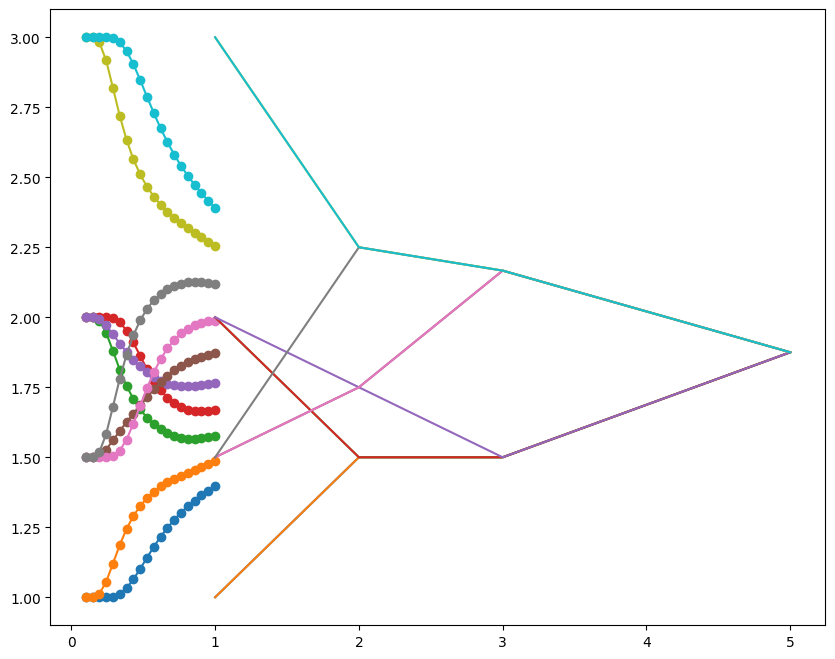

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

X_train = np.array([0, 1, 2, 3])
y_train = np.array([1, 2, 1.5, 3])

def compute_weights(dists, bandwidth):
    dists_squared = np.square(dists)
    denom = 2 * (bandwidth ** 2)
    return np.exp(-dists_squared / denom)

def nadaraya_watson_predict(X_train, y_train, X_test, bandwidth):
    predictions = []
    for x in X_test:
        u = X_train - x
        weights = compute_weights(u, bandwidth)
        total_weights = np.sum(weights)
        prediction = np.sum(weights * y_train) / total_weights
        predictions.append(prediction)
    return np.array(predictions)

# 1 make Nadaraya-Watson prediction with the gaussian kernel and lambda = 0.5, predict for x = 1.5
X_test = np.array([1.5])
predictions = nadaraya_watson_predict(X_train, y_train, X_test, bandwidth=0.5)
print(f'Prediction for x=1.5 with lambda=0.5: {predictions[0]}')

# 2 repeat with lambda = 2. how does the prediction change?
predictions = nadaraya_watson_predict(X_train, y_train, X_test, bandwidth=2)
print(f'Prediction for x=1.5 with lambda=2: {predictions[0]}')

# 3 implement the estimator and plot the predictions for lambda in [0.2, 0.5, 1, 2] in the interval [0, 3]
X_test = np.linspace(0, 3, 10)
bandwidths = np.linspace(0.1, 1, 20)
bandwidth_predictions = { bandwidth: nadaraya_watson_predict(X_train, y_train, X_test, bandwidth) for bandwidth in bandwidths }

plt.figure(figsize=(10, 8))
plt.plot(list(bandwidth_predictions.keys()), list(bandwidth_predictions.values()), marker='o')

# 4 compare visually with kNN for k = [1, 2, 3, 5]. Which method produces smoother predictions?
knn_predictions = {}
for k in [1, 2, 3, 5]:
    knn_preds = knn_regression(X_train, y_train, X_test, k)
    knn_predictions[k] = knn_preds

plt.plot(list(knn_predictions.keys()), list(knn_predictions.values()), label=f'kNN k={k}')
## Nadaraya-Watson produces smoother predictions



## Exercise 7: Computational Complexity

Vous développez un système de recommandation pour une plateforme avec 10 millions d'utilisateurs. Chaque utilisateur est représenté par un vecteur de 100 dimensions (embeddings).

1. Combien d'opérations (multiplications et additions) faut-il pour trouver le plus proche voisin d'un utilisateur par force brute?

2. Si chaque opération prend 1 nanoseconde, quel est le temps de réponse pour une requête?

3. Si vous devez traiter 1000 requêtes par seconde, cette approche est-elle viable?

4. Un arbre k-d réduit la complexité à $O(\log N)$ en basse dimension. Pourquoi cette structure n'est-elle pas efficace pour $d = 100$?

5. Proposez une stratégie pour ce problème à grande échelle.

In [ ]:
## 100m users, 100 features

# 1 how many operations (mult and add) are needed to find the NN by brute force?
# - d subtractions
# - d multiplications
# - d-1 additions
# - 1 square root
# total: 2d + (d-1) + 1 = 3d -> N * 3d -> 10^7 * 3 * 10^2 => 3 * 10^9 operations

# 2 if each operation takes 1ns, what is the response time per request?
# 10^(-9)s/op * 3 * 10^9op = 3s

# 3 if you must handle 1k req/s, is this feasible?
# - 3s/req * 1000req/s -> 3000s of work per second -> not feasible (3k cpus)

# 4 A k-d tree reduces the complexity to O(log N). Why is this structure not effective for d = 100?
# - curse of dimensionality
# - simiilar to kNN, as d increases, the volume of the space increases exponentially, making data points sparse.
# - the partitioning becomes less effective, leading to many branches being explored during search.
# - the overhead of managing the tree structure may outweigh the benefits in high dimensions.

# 5 propose a strategy for this problem at a large scale
# - dimensionality reduction (PCA, t-SNE, UMAP)
# - approximate nearest neighbor search (LSH, Annoy, Faiss)
# - clustering (k-means, hierarchical clustering)
# - hybrid approaches (reduce dimensions, cluster, then search within clusters)